# Computing the channel capacity from experimental data.

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import pickle
import os
import glob
import re
import itertools
import inspect

# Our numerical workhorses
import numpy as np
import mpmath
import scipy.optimize
import scipy.special
import scipy.integrate
import pandas as pd

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

figdir = '../../fig/channel_capacity_experiment/'
tmpdir = '../../tmp/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()

## Computing the channel capacity with bias correction for distribution undersampling.

A difficulty when computing the channel capacity between inputs and outputs from experimental data is that ideally we would like to compute
$$
C(g; c) \equiv \max_{P(c)} I(g; c),
\tag{1}
$$
where $g$ is the gene expression level, and $c$ is the inducer concentration. But in reality we are computing
$$
C(f(g); c) \equiv \max_{P(c)} I(f(g); c),
\tag{2}
$$
where $f(g)$ is a function of gene expression that has to do with our mapping from the YFP copy number to some arbitrary fluorescent value as computed from the images taken with the microscope. 

The *data processing inequality* tells us that
$$
I(g; c) \geq I(f(g); c),
\tag{3}
$$
meaning that we can only lose information when mapping from the real relationship between gene expression and inducer concentration to a fluorescence value.

On top of that given the limited number of samples that we have access to when computing the channel capacity there is a bias in our estimate given this undersampling. The definition of accurate unbiased descriptors of the mutual information is still an area of active research. For our purposes we will use the method described by [Cheong et al.](http://science.sciencemag.org/content/334/6054/354).

The basic idea of the method is to write the mutual information as a series expansion in terms of inverse powers of the sample size, i.e.
$$
I_{\text{biased}} = I_\infty + \frac{a_1}{N} + \frac{a_2}{N^2} + \cdots,
\tag{4}
$$
where $I_{\text{biased}}$ is the biased estimate of the mutual information as computed from experimental data, $I_\infty$ is the quantity we would like to estimate, being the unbiased mutual information when having access to infinity number of experimental samples, and the coefficients $a_i$ depend on the underlying distribution of the signal and the response.

In principle for a good number of data points the termos of higher order become negligible. So we can write the mutual information as
$$
I_{\text{biased}} \approx I_\infty + \frac{a_1}{N} + \mathcal{O}(N^{-2})
\tag{5}
$$

That means that when computing the mutual information for varying number of samples (by taking subsamples of the experimental data) we would expect to find a linear relationship as a function of the inverse of these number of data points where the intercept is a bias-corrected estimate of the mutual information.

We can therefore bootstrap the channel capacity by taking different sample sizes and using the Blahut-Arimoto algorithm we developed earlier to estimate the biased channel capacity. We can then fit a line and extrapolate for when $1/N = 0$ which corresponds to our unbiased estimate of the channel capacity.

## Reading and plotting the distributions for one strain.

To begin our exploration of the theoretical data let's use as an example the `O2+11-YFP; RBS1027-lacI` strain. Let's read the data into memory.

In [3]:
df_micro = pd.read_csv('../../data/csv_microscopy/' + 
                       '20181003_O2_RBS1027_IPTG_titration_microscopy.csv',
                       comment='#')
df_micro.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,area,eccentricity,solidity,mean_intensity,intensity
0,20181003,mrazomej,O2,-13.9,auto,0,0.0,3.7376,0.867840,0.960526,179.874732,672.299799
1,20181003,mrazomej,O2,-13.9,auto,0,0.0,4.3776,0.916271,0.886010,154.484481,676.271263
2,20181003,mrazomej,O2,-13.9,auto,0,0.0,4.7872,0.921537,0.916667,154.909065,741.580676
3,20181003,mrazomej,O2,-13.9,auto,0,0.0,5.3504,0.927201,0.849593,143.195792,766.154765
4,20181003,mrazomej,O2,-13.9,auto,0,0.0,5.1456,0.949710,0.909502,160.459345,825.659605


Now let's look at the distributions.

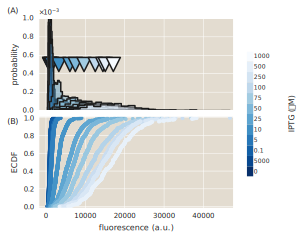

In [4]:
# Select RBS1027 day 1 to start the data exploration
df_group = df_micro[df_micro.rbs == 'RBS1027'].groupby('IPTG_uM')

# Extract concentrations
concentrations = df_micro.IPTG_uM.unique()

# Plot distributions coming from microscopy
# Decide color
colors = sns.color_palette("Blues_r", len(concentrations))

fig, ax = plt.subplots(2, 1, figsize=(3.5, 3.5), sharex=True)

# Set the nice scientific notation for the y axis of the histograms
ax[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))

# Set the number of bins for the histograms
nbins = 20 
# Initialize array to save the mean fluorescence
mean_fl = []

# Loop through each group
for i, (g, data) in enumerate(df_group):
    # Histogram plot
    # Add the filling to the histogram
    n, bins, patches = ax[0].hist(data.intensity, nbins,
                                  density=1, histtype='stepfilled', alpha=0.4,
                                  label=str(g)+ r' $\mu$M', facecolor=colors[i],
                                  linewidth=1)
    # Add a black outline for each histogram
    n, bins, patches = ax[0].hist(data.intensity, nbins,
                                density=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')
    # Save the mean fluorescence 
    mean_fl.append(data.intensity.mean())
    
    # ECDF Plot
    x, y = ccutils.stats.ecdf(data.intensity)
    ax[1].plot(x, y, '.', label=str(g)+ r' $\mu$M', color=colors[i])

# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_plot = ax[0].scatter(mean_fl, [5E-4] * len(mean_fl), marker='v', s=200,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5)
# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
cbar = fig.colorbar(mean_plot, cax=cbar_ax)
cbar.ax.get_yaxis().set_ticks([])
for j, r in enumerate(concentrations):
    if r == 0.1:
        r = str(r)
    else:
        r = str(int(r))
    cbar.ax.text(1, j / len(concentrations) + 1 / (2 * len(concentrations)),
                 r, ha='left', va='center',
                 transform = cbar_ax.transAxes, fontsize=6)
cbar.ax.get_yaxis().labelpad = 35
cbar.set_label(r'IPTG ($\mu$M)')

    
ax[0].set_ylim([0, 1E-3])
ax[0].set_ylabel('probability')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
 
ax[1].margins(0.02)
ax[1].set_xlabel('fluorescence (a.u.)')
ax[1].set_ylabel('ECDF')

plt.figtext(0.0, .9, '(A)', fontsize=8)
plt.figtext(0.0, .46, '(B)', fontsize=8)

plt.subplots_adjust(hspace=0.06)
plt.savefig(figdir + 'O2_RBS1027_distribution_microscopy.pdf', bbox_inches='tight')

Let's zoom in a little more on the histogram.

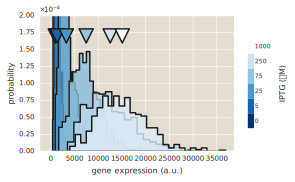

In [30]:
# # Select RBS1027 day 1 to start the data exploration
# df_group = df_micro[df_micro.rbs == 'RBS1027'].groupby('IPTG_uM')

# Extract concentrations
concentrations = np.sort(df_micro.IPTG_uM.unique())[0::2]

# Use only concentrations listed
df_subsample = df_micro[(df_micro.rbs == 'RBS1027') &
                        (df_micro.IPTG_uM.isin(concentrations))]

df_group = df_subsample.groupby('IPTG_uM')

# Plot distributions coming from microscopy
# Decide color
colors = sns.color_palette("Blues_r", len(concentrations))

fig, ax = plt.subplots(1, 1)

# Set the nice scientific notation for the y axis of the histograms
ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter(\
                             useMathText=True, 
                             useOffset=False))

# Set the number of bins for the histograms
nbins = 25
# Initialize array to save the mean fluorescence
mean_fl = []

# Loop through each group
for i, (g, data) in enumerate(df_group):
    # Histogram plot
    # Add the filling to the histogram
    n, bins, patches = ax.hist(data.intensity, nbins,
                                  density=1, histtype='stepfilled', alpha=0.8,
                                  label=str(g)+ r' $\mu$M', facecolor=colors[i],
                                  linewidth=1)
    # Add a black outline for each histogram
    n, bins, patches = ax.hist(data.intensity, nbins,
                                density=1, histtype='stepfilled', 
                                label='', edgecolor='k',
                               linewidth=1.5, facecolor='none')
    # Save the mean fluorescence 
    mean_fl.append(data.intensity.mean())
    
# Declare color map for legend
cmap = plt.cm.get_cmap('Blues_r', len(concentrations))
bounds = np.linspace(0, len(concentrations), len(concentrations) + 1)

# Plot a little triangle indicating the mean of each distribution
mean_plot = ax.scatter(mean_fl, [1.7E-4] * len(mean_fl), marker='v', s=200,
            c=np.arange(len(mean_fl)), cmap=cmap,
            edgecolor='k',
            linewidth=1.5, zorder=10)
# Generate a colorbar with the concentrations
cbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])
cbar = fig.colorbar(mean_plot, cax=cbar_ax)
cbar.ax.get_yaxis().set_ticks([])
for j, r in enumerate(concentrations):
    if r == 0.1:
        r = str(r)
    else:
        r = str(int(r))
    cbar.ax.text(1, j / len(concentrations) + 1 / (2 * len(concentrations)),
                 r, ha='left', va='center',
                 transform = cbar_ax.transAxes, fontsize=6)
cbar.ax.get_yaxis().labelpad = 25
cbar.set_label(r'IPTG ($\mu$M)')

    
ax.set_ylim([0, 2E-4])
ax.set_ylabel('probability')
ax.set_xlabel('gene expression (a.u.)')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
 
plt.savefig(figdir + 'O2_RBS1027_histogram_microscopy.pdf', bbox_inches='tight')

###  Computing the experimental transition matrix $\mathbf{Q}_{g\mid c}$

In order to compute the channel capacity, we feed a matrix $\mathbf{Q}_{g\mid c}$ to the algorithm that then finds the distribution array $\mathbf{p}_c$ that maximizes the information transmission through the noisy channel. To build this matrix from experimental data we need to bin the fluorecence values with a predetermined number of bins.

We now define a function that builds this matrix from a tidy data frame containing the concentration column and the single-cell fluorescent measurements.

In [14]:
def trans_matrix(df, bins, frac=None,
                 output_col='intensity', group_col='IPTG_uM'):
    '''
    Builds the transition matrix P(m|C) from experimental data contained in a
    tidy dataframe. The matrix is build by grouping the data according to the
    entries from group_col.
    Parameters
    ----------
    df : pandas Dataframe
        Single cell output reads measured at different inducer concentrations. 
        The data frame must contain a column output_col that will be binned to
        build the matrix, and a matrix group_col that will be used to group
        the different inputs.
    bins : int.
        Number of bins to use when building the empirical PMF of the data set.
        If `bins` is a string from the list below, `histogram` will use
        the method chosen to calculate the optimal bin width and
        consequently the number of bins from the data that falls within 
        the requested range.
    frac : None or float [0, 1]
        Fraction of the data to sample for building the matrix. Default = None
        meaning that the entire data set will be used. The fraction of data is 
        taken per input value.
    output_col : str.
        Name of the column that contains the quantity (usually fluorescence 
        measurements) to be binned in order to build the matrix
    group_col : str.
        Name of the column that contains the inputs C of the matrix (usually
        inducer concentrations). This column will be used to separate the
        different rows ot the transition matrix.
    Returns
    -------
    QmC : array-like.
        Experimentally determined input-output function.
    len(df) : int
        Number of data points considered for building the matrix
    '''
    
    # Extract the data to bin
    bin_data = df[output_col]
    
    # indicate the range in which bin the data
    bin_range = [np.min(bin_data), np.max(bin_data)]
    
    # If inidicated select a fraction frac of the data at random
    if frac != None:
        # Group by group_col and take samples
        group = df.groupby(group_col)
        # Initialize data frame to save samples
        df_sample = pd.DataFrame()
        for g, d in group:
            df_sample = pd.concat([df_sample, d.sample(frac=frac)])
        # Use the subsample data frame
        df = df_sample
    
    # Extract the number of unique inputs in the data frame
    n_inputs = df.IPTG_uM.unique().size
    
    # Initialize transition matrix
    QmC = np.zeros([bins, n_inputs])
    
    # Loop through different groups
    for k, (c, f) in enumerate(df.groupby(group_col)):
        # Obtain the empirical PMF from the experimental data
        p, bin_edges = np.histogram(f[output_col], bins=int(bins), 
                                    range=bin_range)
        # Normalized the empirical PMF. We don't use the option from numpy
        # because it DOES NOT build a PMF but assumes a PDF.
        p = p / np.sum(p)
        # Add column to matrix
        QmC[:, k] = p
   
    return QmC, len(df)

### Bootstraping the channel capacity

Now that we have the function to build the transition matrix $\mathbf{Q}_{g\mid c}$ let's now test the unbiased estimator. We will build the transition matrix with varying number of data points and compute the channel capacity on each occasion.

To make the estimate more robust we will repeat the sampling multiple times to account for the variability in the random subsampling. So let us define a function that given a fraction `frac` and a number of repeats `nrep` computes the channel capacity `nrep` times taking different random samples on each time.

In [15]:
def channcap_bootstrap(df, nrep, bins, frac, **kwargs):
    '''
    Given a fraction of the data frac computes the channel capacity nrep times
    taking different random samples on each time.
    Parameters
    ----------
    df : pandas Dataframe
        Single cell output reads measured at different inducer concentrations. 
        The data frame must contain a column output_col that will be binned to
        build the matrix, and a matrix group_col that will be used to group
        the different inputs.
    bins : int.
        Number of bins to use when building the empirical PMF of the data set.
        If `bins` is a string from the list below, `histogram` will use
        the method chosen to calculate the optimal bin width and
        consequently the number of bins from the data that falls within 
        the requested range.
    frac : float [0, 1]
        Fraction of the data to sample for building the matrix. 
        The fraction of data is taken per input value.
    kwargs : dictionary
        Optional arguments that can be passed to the trans_matrix function.
        Optional arguments that can be passed to the channel_capacity function.
    '''
    # Extract arguments for trans_matrix function
    tm_arg_names =  trans_matrix.__code__.co_varnames\
                        [0:trans_matrix.__code__.co_argcount]
    tm_kwargs = dict((k, kwargs[k]) for k in tm_arg_names if k in kwargs)
    
    # Extract the arguments for the channel capacity function
    cc_arg_names =  ccutils.channcap.channel_capacity.__code__.co_varnames\
                        [0:ccutils.channcap.channel_capacity.__code__.co_argcount]
    cc_kwargs = dict((k, kwargs[k]) for k in cc_arg_names if k in kwargs)
    
    # Initialize array to save channel capacities
    MI = np.zeros(nrep)
    for i in np.arange(nrep):
        QgC, samp_size = trans_matrix(df, bins=bins, frac=frac,  **tm_kwargs)
        MI[i] = ccutils.channcap.channel_capacity(QgC.T, **cc_kwargs)[0]
    
    return MI, samp_size

Let's test the algorithm

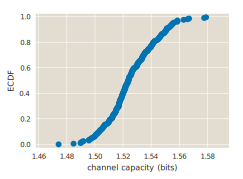

In [16]:
# Extract the data from the experimental strain
df_exp = df_micro[df_micro.rbs == 'RBS1027']
# run the bootstrap sample for a single fraction of the data
MI, samp_size = channcap_bootstrap(df_exp, 200, 100, 0.5)
x, y = ccutils.stats.ecdf(MI)
plt.scatter(x, y, edgecolors='none')
plt.xlabel('channel capacity (bits)')
plt.ylabel('ECDF')
plt.margins(0.01)
plt.savefig(figdir + 'bootstrap_ecdf_channcap.pdf')

There is definitely some variability in the estimates. So it is important to perform a good number of these bootstrap estimates for each fraction.

Let's now run the Blahut-Arimoto algorithm for different fractions and different number of bins.

We will define a function that runs each bin in parallel to speed up the computation time.

In [22]:
# Set the number of bins and the fraction of data to use
fracs = np.linspace(0.1, 1, 10)
bins = np.floor(np.linspace(10, 100, 10)).astype(int)
nreps = 15

# Define function to perform the computation in paralel
def channcap_bs_parallel(b):
    # Initialize matrix to save bootstrap repeats
    MI_bs = np.zeros([len(fracs), nreps])
    samp_sizes = np.zeros(len(fracs))
    for i, frac in enumerate(fracs):
        MI_bs[i, :], samp_sizes[i] = channcap_bootstrap(df_exp, bins=b,
                                                    nrep=nreps, frac=frac)
    return (MI_bs, samp_sizes)

channcap_list = Parallel(n_jobs=6)(delayed(channcap_bs_parallel)(b) \
                                   for b in bins)

Given the inconvenient data type that we return with this function, let's define a simple function that transforms it into a tidy data frame since we will be running this function multiple times and it is useful to save these bootstrap estimates.

In [23]:
def tidy_df_channcap_bs(channcap_list, fracs, bins, **kwargs):
    '''
    Breaks up the output of channcap_bs_parallel into a tidy data frame.
    Parameters
    ----------
    channcap_list : list of length len(bins)
        List containing the channel capacity bootstrap repeats for each bin.
        Each entry in the list contains 2 elements:
        1) MI_bs : matrix of size len(fracs) x nreps
        This matrix contains on each row the nreps bootrstrap estimates for a
        fraction of the data frac.
        2) samp_sizes : array of length len(fracs)
        This array keeps the amount of data used for each of the fractions
        indicated.
    fracs : array-like
        Array containing the fractions at which the bootstrap estimates were 
        computed.
    bins : array-like.
        Number of bins used when generating the matrix Qg|c
    kwargs : dictionary
        Dictionary containing extra fields to be included in the tidy dataframe.
        Every entry in this dictionary will be added to all rows of the dataframe.
        Examples of relevant things to add:
        - date of the sample
        - username that generated the data
        - operator
        - binding_energy
        - rbs
        - repressors
    Returns
    -------
    Tidy dataframe of the channel capacity bootstrap samples
    '''
    # Initialize data frame where all the information will be saved
    df = pd.DataFrame()
    
    # Loop through the elements of the list containing the bs samples
    # for each number of bins
    for i, b in enumerate(bins):
        # Extract the sample element
        bin_samples = channcap_list[i] 
        # Loop through each of the rows of the MI_bs matrix containing the
        # nrep samples for each fraction
        for j, s in enumerate(bin_samples[0]):
            # Initialize df to save the outcomes from this specific fraction
            df_frac = pd.DataFrame(s, columns=['channcap_bs'])
            # Save sample size
            df_frac['samp_size'] = [bin_samples[1][j]] * len(s)
            # Save fraction of data used
            df_frac['frac'] = [fracs[j]] * len(s)
            # Save the number of bins used for this bs samples
            df_frac['bins'] = [b] * len(s)    
            # append to the general data frame
            df = pd.concat([df, df_frac], axis=0)
        
    
    # Add elements contained in the kwards dictioary
    for key, value in kwargs.items():
        df[key] = [value] * len(df)
    
    return df

In [24]:
# Define elements to extract from the microscopy data frame to add to the
# Bootstrap data frame
kwarg_list = ['date', 'username', 'operator', 'binding_energy',  'rbs', 
              'repressors']
kwargs = dict((x, df_exp[x].unique()[0]) for x in kwarg_list)
df_cc_bs = tidy_df_channcap_bs(channcap_list, fracs, bins, **kwargs)
df_cc_bs.head()

,channcap_bs,samp_size,frac,bins,date,username,operator,binding_energy,rbs,repressors
0,1.062796,501.0,0.1,10,20181003,mrazomej,O2,-13.9,RBS1027,260
1,1.088671,501.0,0.1,10,20181003,mrazomej,O2,-13.9,RBS1027,260
2,1.217916,501.0,0.1,10,20181003,mrazomej,O2,-13.9,RBS1027,260
3,1.099182,501.0,0.1,10,20181003,mrazomej,O2,-13.9,RBS1027,260
4,1.094853,501.0,0.1,10,20181003,mrazomej,O2,-13.9,RBS1027,260


### Plotting (sample size)$^{-1}$ vs. channel capacity

Having created the tidy data frame now is easy to plot the inverse of the sample size vs. the channel capacity to see if indeed there is a linear relationship between these two as we expect from the unbiased estimator.

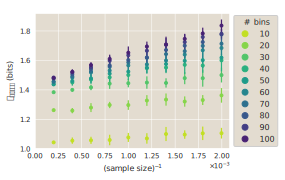

In [25]:
df_bin_group = df_cc_bs.groupby(['bins', 'samp_size'])

bins = df_cc_bs.bins.unique()
bin_color = dict(zip(bins[::-1], sns.color_palette('viridis', n_colors=len(bins))))

fig, ax = plt.subplots(1, 1)
for group, data in df_bin_group:
    ax.errorbar(x=1 / group[1],
                 y=data['channcap_bs'].mean(), 
                 yerr=data['channcap_bs'].std(), 
                 fmt='o', color=bin_color[group[0]],
                 label=None, markersize=3)

# add legend
for b in bins:
    ax.errorbar([], [], color=bin_color[b], label=b, fmt='o')
    
ax.legend(loc='center left', title='# bins', 
          bbox_to_anchor=(1.0, 0.5))

# Set limits
ax.set_xlim(left=0)
ax.set_ylim(bottom=1)

# Label axis
ax.set_xlabel(r'(sample size)$^{-1}$')
ax.set_ylabel(r'$I_{biased}$ (bits)')

# Set a nice scientific notation for the x axis
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),
                    useMathText=True)

With the bootstrap samples the relationship looks indeed linear as we predicted from the asymptotic expansion of the channel capacity.

### Extrapolating to $I_\infty$

Now that we have the bootstrapping samples we can perform a linear regression to obtain the unbiased estimator of the channel capacity $I_\infty$. For this we will use the `np.polyfit` function.

In [26]:
# Group by the number of bins
df_group = df_cc_bs.groupby('bins')
# Initialize arrays to save the slope and intercept of the linear regression
lin_reg = np.zeros([len(bins), 2])

# Loop through each bin size and find the intercept
for i, (group, data) in enumerate(df_group):
    # Define the inverse sample size as x values
    x = 1 / data.samp_size
    # Set channel capacity as y values
    y = data.channcap_bs
    # Perform the linear regression
    lin_reg[i, :] = np.polyfit(x, y, deg=1)

Let's now plot the bootstrap estimates on top of the linear regression.

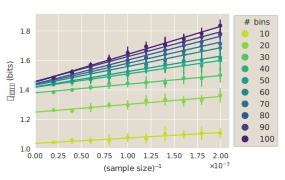

In [27]:
df_bin_group = df_cc_bs.groupby(['bins', 'samp_size'])

bins = df_cc_bs.bins.unique()
bin_color = dict(zip(bins, sns.color_palette('viridis_r',  n_colors=len(bins))))

fig, ax = plt.subplots(1, 1)
# Define the xlims that will use as evaluating points for the linear regression
xlims = [0, 2E-3]
# add legend and line
for i, b in enumerate(bins):
    ax.errorbar([], [], color=bin_color[b], label=b, fmt='o')
    ax.plot(xlims, np.polyval(lin_reg[i, :], xlims),
           color=bin_color[b], label=None)

for group, data in df_bin_group:
    ax.errorbar(x=1 / group[1],
                 y=data['channcap_bs'].mean(), 
                 yerr=data['channcap_bs'].std(), 
                 fmt='o', color=bin_color[group[0]],
                 label=None, markersize=3)

ax.legend(loc='center left', title='# bins', bbox_to_anchor=(1.0, 0.5))

# Set limits
ax.set_xlim(left=0)
ax.set_ylim(bottom=1)

# Label axis
ax.set_xlabel(r'(sample size)$^{-1}$')
ax.set_ylabel(r'$I_{biased}$ (bits)')

# Set a nice scientific notation for the x axis
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),
                    useMathText=True)

plt.savefig(figdir + 'I_infty_lin_reg.pdf', bbox_inches='tight')

## Computing $I_\infty$ for a fine grid of number of bins.

We will follow Cheong et all and compute the unbiased channel capacity estimator for a finer grid. Since this will be computationally expensive, we will save the data frame containing the bootstrap estimates.

In [ ]:
# Define output directory
outputdir = '../../data/csv_channcap_bootstrap/'
# Group by date and rbs removing the auto and delta
df_date_group = df_micro[(df_micro.rbs != 'auto') &
                         (df_micro.rbs != 'delta')].groupby(['date', 'rbs'])

# Determine the parameters for the bootstraping
# bins = np.arange(1000, 2000, 500) # range of bins to use
bins = np.floor(np.logspace(0, 4, 100))
fracs = 1 / np.linspace(1 / 0.6, 1, 10)
nrep = 25 # number of bootstrap samples per fraction

for group, df in df_date_group:
    print('date : {:d}'.format(group[0]))
    print('rbs : ' + group[1])
    # Define the parallel function to run
    def channcap_bs_parallel(b):
        # Initialize matrix to save bootstrap repeats
        MI_bs = np.zeros([len(fracs), nreps])
        samp_sizes = np.zeros(len(fracs))
        for i, frac in enumerate(fracs):
            MI_bs[i, :], samp_sizes[i] = channcap_bootstrap(df, bins=b,
                                                        nrep=nreps, frac=frac)
        return (MI_bs, samp_sizes)

    # Perform the parallel computation
    channcap_list = Parallel(n_jobs=7)(delayed(channcap_bs_parallel)(b) \
                                       for b in bins)
    print('Done performing calculations.')
    # Define the parameters to include in the data frame
    kwarg_list = ['date', 'username', 'operator', 'binding_energy',  'rbs', 
                  'repressors']
    # Extract the parameters from the data frame
    kwargs = dict((x, df[x].unique()[0]) for x in kwarg_list)
    # Convert the list into a tidy data frame
    df_cc_bs = tidy_df_channcap_bs(channcap_list, fracs, bins, **kwargs)
    # Save outcome
    filename = str(kwargs['date']) + '_' + kwargs['operator'] + '_' +\
               kwargs['rbs'] + '_' + 'channcap_bootstrap.csv'
    df_cc_bs.to_csv(outputdir + filename, index=False)
    print('Saved as dataframe.')

# Analyzing the estimates of $I_\infty$

Let's compute unbiased channel capacity estimate for all the bins previously computed.

First we will read the data frames into a single one.

In [43]:
read_files = glob.glob('../../data/csv_channcap_bootstrap/*bootstrap.csv')
df_bs = pd.concat(pd.read_csv(f, comment='#') for f in read_files)
df_bs.head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,binding_energy,bins,channcap_bs,date,frac,operator,rbs,repressors,samp_size,username
0,-13.9,1.0,0.0,20181003,0.6,O2,RBS1027,260,3002.0,mrazomej
1,-13.9,1.0,0.0,20181003,0.6,O2,RBS1027,260,3002.0,mrazomej
2,-13.9,1.0,0.0,20181003,0.6,O2,RBS1027,260,3002.0,mrazomej
3,-13.9,1.0,0.0,20181003,0.6,O2,RBS1027,260,3002.0,mrazomej
4,-13.9,1.0,0.0,20181003,0.6,O2,RBS1027,260,3002.0,mrazomej


Let's now perform the linear regression for each date and each number of bins.

In [45]:
# Group by the number of bins
df_group = df_bs.groupby(['date', 'operator', 'rbs', 'bins'])

# Initialize data frame to save the I_oo estimates
df_cc = pd.DataFrame(columns=['date', 'operator', 'rbs', 'bins', 'channcap'])
for group, data in df_group:
    x = 1 / data.samp_size
    y = data.channcap_bs
    # Perform linear regression
    lin_reg = np.polyfit(x, y, deg=1)
    df_tmp = pd.Series(list(group) + [lin_reg[1]],
             index=['date', 'operator', 'rbs', 'bins', 'channcap'])
    df_cc = df_cc.append(df_tmp, ignore_index=True)

# Convert date and bins into integer
df_cc[['date', 'bins']] = df_cc[['date', 'bins']].astype(int)
df_cc.head()

,date,operator,rbs,bins,channcap
0,20161018,O2,RBS1027,1,0.000000
1,20161018,O2,RBS1027,2,0.102440
2,20161018,O2,RBS1027,3,0.345032
3,20161018,O2,RBS1027,4,0.521909
4,20161018,O2,RBS1027,5,0.666366


Now let's plot the channel capacity as a function of bin size for the O2 - RBS1027 experiment that we've been studying so far.

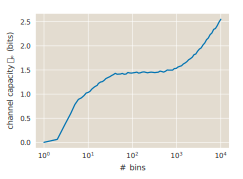

In [73]:
# Group by date
df_O2_1027 = df_cc[df_cc['date'] == 20181003]

# Initialize figure
fig, ax = plt.subplots(1, 1)
ax.plot(df_O2_1027.bins, df_O2_1027.channcap, label=g)

ax.set_xlabel('# bins')
ax.set_ylabel(r'channel capacity $I_\infty$ (bits)')
ax.set_xscale('log')

We can distinguish three phases in this plot:
1. A rapid increment from 0 bits to about 1.5 bits as the number of bins increases.
2. A flat region between $\approx$ 50 and 1000 bins.
3. A second rapid increment for large number of bins.

As Cheong et al. suggested, the flat region contains the best estimate of the channel capacity. The first stage underestimates the channel capacity due to poor binning of the data, while the last region starts running into over-binning that generates separated peaks that artificially increase the channel capacity.

## Computing the channel capacity of randomized data

As a control to observe when the channel capacity increases due to "over-binning", we will perform the same bootstrapping analysis but this time using randomized data.

The way we will perform the randomization will be by shuffling the fluorescence values to pair them with random concentrations.

In [ ]:
# Define output directory
outputdir = '../../data/csv_channcap_bootstrap/'
# Group by date and rbs removing the auto and delta
df_date_group = df_micro[(df_micro.rbs != 'auto') &
                         (df_micro.rbs != 'delta')].groupby(['date', 'rbs'])

# Determine the parameters for the bootstraping
bins = np.floor(np.logspace(0, 4, 100))
fracs = 1 / np.linspace(1 / 0.6, 1, 10)
nreps = 25 # number of bootstrap samples per fraction

for group, df in df_date_group:
    print('date : {:d}'.format(group[0]))
    print('rbs : ' + group[1])
    print('shuffling mean_intensity data')
    df = df.assign(shuffled=df.mean_intensity.sample(frac=1).values)
    # Define the parallel function to run
    def channcap_bs_parallel(b):
        # Initialize matrix to save bootstrap repeats
        MI_bs = np.zeros([len(fracs), nreps])
        samp_sizes = np.zeros(len(fracs))
        for i, frac in enumerate(fracs):
            MI_bs[i, :], samp_sizes[i] = channcap_bootstrap(df, bins=b,
                                         nrep=nreps, frac=frac,
                                         **{'output_col' : 'shuffled'})
        return (MI_bs, samp_sizes)

    # Perform the parallel computation
    channcap_list = Parallel(n_jobs=7)(delayed(channcap_bs_parallel)(b) \
                                       for b in bins)
    print('Done performing calculations.')
    # Define the parameters to include in the data frame
    kwarg_list = ['date', 'username', 'operator', 'binding_energy',  'rbs', 
                  'repressors']
    # Extract the parameters from the data frame
    kwargs = dict((x, df[x].unique()[0]) for x in kwarg_list)
    # Convert the list into a tidy data frame
    df_cc_bs = tidy_df_channcap_bs(channcap_list, fracs, bins, **kwargs)
    # Save outcome
    filename = str(kwargs['date']) + '_' + kwargs['operator'] + '_' +\
               kwargs['rbs'] + '_' + 'channcap_bootstrap_shuffled.csv'
    df_cc_bs.to_csv(outputdir + filename, index=False)
    print('Saved as dataframe.')

Let's read all of the shuffled data generated so far.

In [78]:
read_files = glob.glob('../../data/csv_channcap_bootstrap/*bootstrap_shuffled.csv')
df_bs_rnd = pd.concat(pd.read_csv(f, comment='#') for f in read_files)
df_bs_rnd.head()

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,binding_energy,bins,channcap_bs,date,frac,operator,rbs,repressors,samp_size,username
0,-13.9,1.0,0.0,20161020,0.6,O2,RBS1027,130,1274.0,gchure
1,-13.9,1.0,0.0,20161020,0.6,O2,RBS1027,130,1274.0,gchure
2,-13.9,1.0,0.0,20161020,0.6,O2,RBS1027,130,1274.0,gchure
3,-13.9,1.0,0.0,20161020,0.6,O2,RBS1027,130,1274.0,gchure
4,-13.9,1.0,0.0,20161020,0.6,O2,RBS1027,130,1274.0,gchure


Now let's perform the linear regression.

In [79]:
# Group by the number of bins
df_group = df_bs_rnd.groupby(['date', 'operator', 'rbs', 'bins'])

# Initialize data frame to save the I_oo estimates
df_cc_shuff = pd.DataFrame(columns=['date', 'operator', 'rbs', 'bins', 'channcap'])
for group, data in df_group:
    x = 1 / data.samp_size
    y = data.channcap_bs
    # Perform linear regression
    lin_reg = np.polyfit(x, y, deg=1)
    df_tmp = pd.Series(list(group) + [lin_reg[1]],
             index=['date', 'operator', 'rbs', 'bins', 'channcap'])
    df_cc_shuff = df_cc_shuff.append(df_tmp, ignore_index=True)

# Convert date and bins into integer
df_cc_shuff[['date', 'bins']] = df_cc_shuff[['date', 'bins']].astype(int)
df_cc_shuff.head()

,date,operator,rbs,bins,channcap
0,20161018,O2,RBS1027,1,0.000000
1,20161018,O2,RBS1027,2,-0.003177
2,20161018,O2,RBS1027,3,-0.004279
3,20161018,O2,RBS1027,4,-0.002759
4,20161018,O2,RBS1027,5,0.000882


Again let's look at the randomized data for the specific dataset that we've been analyzing.

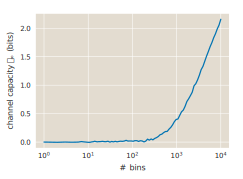

In [80]:
# Group by date
df_O2_1027_shuff = df_cc_shuff[df_cc_shuff['date'] == 20181003]

# Initialize figure
fig, ax = plt.subplots(1, 1)
ax.plot(df_O2_1027_shuff.bins, df_O2_1027_shuff.channcap)

ax.set_xlabel('# bins')
ax.set_ylabel(r'channel capacity $I_\infty$ (bits)')
ax.set_xscale('log')

We can see that the randomized data presents two phases only: 
1. A flat region where there is, as expected no information being processed since the structure of the data was lost when the data was shuffled.
2. A region with fast growth of the channel capacity as the over-binning generates separated peaks on the distribution, making it look like there is structure in the data.

### Comparison of the real vs. the shuffled data.

Now that we have the real and the shuffled data  channel capacity bootstrap samples let's compare them next to each other.

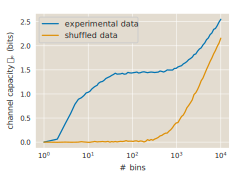

In [83]:
# Group by date
df_O2_1027_shuff = df_cc_shuff[df_cc_shuff['date'] == 20181003]

# Initialize figure
fig, ax = plt.subplots(1, 1)
# Plot real data
ax.plot(df_O2_1027.bins, df_O2_1027.channcap, 
        label='experimental data')
# Plot shuffled data
ax.plot(df_O2_1027_shuff.bins, df_O2_1027_shuff.channcap, 
        label='shuffled data')

# Label axis
ax.set_xlabel('# bins')
ax.set_ylabel(r'channel capacity $I_\infty$ (bits)')

# Set x scale to log
ax.set_xscale('log')

# Add legend
plt.legend()

# Save figure
plt.savefig(figdir + 'bins_vs_channcap.pdf', bbox_inches='tight')

We can see that around $10^2$ bins the channel capacity is flat for both, the experimental and randomized data. So we take this number of bins as our best estimate for the experimental channel capacity.